# Übungsblatt 11
## Präsenzaufgaben
### Aufgabe 1 &nbsp;&nbsp;&nbsp; Grammatikinduktion
In dieser Aufgabe soll vollautomatisch aus Daten (Syntaxbäumen) eine probabilistische, kontextfreie Grammatik erzeugt werden.

Füllen Sie die Lücken und versuchen Sie mithilfe Ihrer automatisch erstellten Grammatik die folgenden Sätze zu parsen:

In [1]:
test_sentences = [
    "the men saw a car .",
    "the woman gave the man a book .",
    "she gave a book to the man .",
    "yesterday , all my trouble seemed so far away ."
]

In [2]:
import nltk
from nltk.corpus import treebank
from nltk.grammar import ProbabilisticProduction, PCFG

In [3]:
# Production count: the number of times a given production occurs
pcount = {}

# LHS-count: counts the number of times a given lhs occurs
lcount = {}

for tree in treebank.parsed_sents():
    for prod in tree.productions():
        pcount[prod] = pcount.get(prod, 0) + 1
        lcount[prod.lhs()] = lcount.get(prod.lhs(), 0) + 1
        
productions = [
    ProbabilisticProduction(
        p.lhs(), p.rhs(),
        prob=pcount[p] / lcount[p.lhs()]
    )
    for p in pcount
]

start = nltk.Nonterminal('S')
grammar = PCFG(start, productions)
parser = nltk.ViterbiParser(grammar)

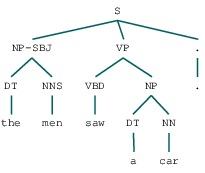

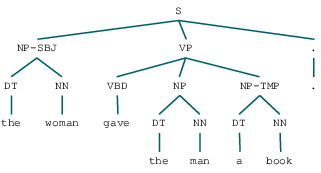

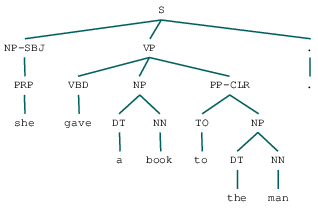

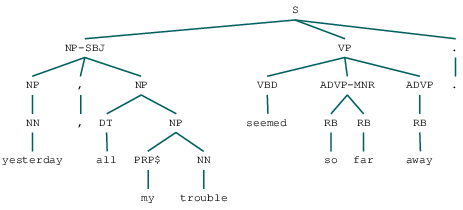

In [4]:
from IPython.display import display

for s in test_sentences:
    for t in parser.parse(s.split()):
        display(t)

### Aufgabe 2 &nbsp;&nbsp;&nbsp; Informationsextraktion per Syntaxanalyse
Gegenstand dieser Aufgabe ist eine anwendungsnahe Möglichkeit, Ergebnisse einer Syntaxanalyse weiterzuverarbeiten. Aus den syntaktischen Abhängigkeiten eines Textes soll (unter Zuhilfenahme einiger Normalisierungsschritte) eine semantische Repräsentation der im Text enthaltenen Informationen gewonnen werden.

Für die syntaktische Analyse soll der `DependencyParser` der Stanford CoreNLP Suite verwendet werden. Die semantische Repräsentation eines Satzes sei ein zweistelliges, logisches Prädikat, dessen Argumente durch Subjekt und Objekt gefüllt sind. (Bei Fehlen eines der beiden Elemente soll `None` geschrieben werden.)

Folgendes Beispiel illustriert das gewünschte Ergebnis:

Eingabe:

    I shot an elephant in my pajamas.
    The elephant was seen by a giraffe in the desert.
    The bird I need is a raven.
    The man who saw the raven laughed out loud.

Ausgabe:

    shot(I, elephant)
    seen(giraffe, elephant)
    need(I, bird)
    raven(bird, None)
    saw(man, raven)
    laughed(man, None)

Beachten Sie, dass `PATH_TO_CORE` in folgender Code-Zelle Ihrem System entsprechend angepasst werden muss!

In [5]:
from nltk.parse.stanford import StanfordDependencyParser

PATH_TO_CORE = "/pfad/zu/stanford-corenlp-full-2017-06-09"
jar = PATH_TO_CORE + '/' + "stanford-corenlp-3.8.0.jar"
model = PATH_TO_CORE + '/' + "stanford-corenlp-3.8.0-models.jar"

dep_parser = StanfordDependencyParser(
    jar, model,
    model_path="edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz"
)

In [6]:
from collections import defaultdict

def generate_predicates_for_sentence(sentence):
    verbs = set()
    sbj = {}
    obj = {}
    sbj_candidates = defaultdict(list)
    case = {}
    relcl_triples = []
    for result in dep_parser.raw_parse(sentence):
        for triple in result.triples():
            # print(*triple)
            
            if triple[1] == "nsubj":
                # whenever we find a subject, its head can be called verb
                # if something is added twice it does not matter --> sets
                # so it is better to add too often than not enough !
                # remember that nouns can be "verbs" in that sense together with copula
                verbs.add(triple[0])
                sbj[triple[0]] = triple[2]
            
            if triple[1] == "dobj" or triple[1] == "nsubjpass":
                # everything that has a direct object should be called a verb as well
                verbs.add(triple[0])
                obj[triple[0]] = triple[2]
            
            if triple[0][1].startswith('V'):
                # everything with a 'verb' as part of speech can be called a verb
                verbs.add(triple[0])
                if triple[1] == "nmod":
                    sbj_candidates[triple[0]].append(triple[2])
                    
            if triple[1] == "case":
                case[triple[0]] = triple[2][0]
                
            if triple[1] == "acl:relcl":
                relcl_triples.append(triple)
                
    for triple in relcl_triples:
        if triple[2] not in sbj or sbj[triple[2]][1] in ["WP", "WDT"]:
            sbj[triple[2]] = triple[0]
        else:
            obj[triple[2]] = triple[0]
                    
    for v in verbs:
        if v not in sbj:
            if v in sbj_candidates:
                for cand in sbj_candidates[v]:
                    if case[cand] == "by":
                        sbj[v] = cand
 
    predicates = []
    for v in verbs:
        if v in sbj:
            subject = sbj[v]
        else:
            subject = ("None",)
        if v in obj:
            object = obj[v]
        else:
            object = ("None",)
        predicates.append(
            v[0] + "(" + subject[0] + ", " + object[0] + ")"
        )
    
    return predicates

In [7]:
for pred in generate_predicates_for_sentence(
    "The man who saw the raven laughed out loud."
):
    print(pred)

laughed(man, None)
saw(man, raven)


In [8]:
def generate_predicates_for_text(text):
    predicates = []
    for sent in nltk.tokenize.sent_tokenize(text):
        predicates.extend(generate_predicates_for_sentence(sent))
    return predicates

In [9]:
text = """
I shot an elephant in my pajamas.
The elephant was seen by a giraffe.
The bird I need is a raven.
The man who saw the raven laughed out loud.
"""

for pred in generate_predicates_for_text(text):
    print(pred)

shot(I, elephant)
seen(giraffe, elephant)
need(I, bird)
raven(bird, None)
laughed(man, None)
saw(man, raven)


## Hausaufgaben
### Aufgabe 3 &nbsp;&nbsp;&nbsp; Parent Annotation
*Parent Annotation* kann die Performanz einer CFG wesentlich verbessern. Schreiben Sie eine Funktion, die einen gegebenen Syntaxbaum dieser Optimierung unterzieht. Auf diese Art und Weise transformierte Bäume können dann wiederum zur Grammatikinduktion verwendet werden.

`parentHistory` soll dabei die Anzahl der Vorgänger sein, die zusätzlich zum direkten Elternknoten berücksichtigt werden. (Kann bei der Lösung der Aufgabe auch ignoriert werden.)

`parentChar` soll ein Trennzeichen sein, das bei den neuen Knotenlabels zwischen dem ursprünglichen Knotenlabel und der Liste von Vorgängern eingefügt wird.

In [10]:
def parent_annotation(tree, parentHistory=0, parentChar="^"):
    pass

In [11]:
test_tree = nltk.Tree(
    "S",
    [
        nltk.Tree("NP", [
            nltk.Tree("DET", []),
            nltk.Tree("N", [])
        ]),
        nltk.Tree("VP", [
            nltk.Tree("V", []),
            nltk.Tree("NP", [
                nltk.Tree("DET", []),
                nltk.Tree("N", [])
            ])
        ])
    ]
)

parent_annotation(
   test_tree
)

### Aufgabe 4 &nbsp;&nbsp;&nbsp; Mehr Semantik für IE
Zusätzlich zu den in Aufgabe 2 behandelten Konstruktionen sollen jetzt auch negierte und komplexe Sätze mit Konjunktionen sinnvoll verarbeitet werden.

Eingabe:

    I see an elephant.
    You didn't see the elephant.
    Peter saw the elephant and drank wine.
    
Gewünschte Ausgabe:

    see(I, elephant)
    not_see(You, elephant)
    saw(Peter, elephant)
    drank(Peter, wine)

Kopieren Sie am besten Ihren aktuellen Stand von oben herunter und fügen Sie Ihre Erweiterungen dann hier ein.

In [12]:
def generate_predicates_for_sentence(sentence):
    pass
def generate_predicates_for_text(text):
    pass

In [13]:
text = """
I see an elephant.
You didn't see the elephant.
Peter saw the elephant and drank wine.
"""